In [57]:
import pandas as pd
import anndata as ad
import numpy as np
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

## Remove CODEX markers that didn't work

In [1]:
full_adata = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata_merged_both_slides.h5ad")

/scratch/lyarab/micromamba/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [2]:
cols_to_drop = ['CD163', 'CD16', 'CXCL13']
full_adata.obs = full_adata.obs.drop(columns=cols_to_drop)

## Transform CODEX intensities (log1p)

In [4]:
# preserve raw data
full_adata.raw = full_adata.copy()

codex_channels = ['DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG',
                  'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14',
                  'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69',
                  'Podoplanin', 'PNAd']

# Apply log1p only to the CODEX channel columns
full_adata.obs[codex_channels] = np.log1p(full_adata.obs[codex_channels])

In [9]:
# save transformed adata
output_path = "/media/Lynn/data/Integrated_data/adata_merged_both_slides_log1p.h5ad"
full_adata.write(output_path)

## Check that we have the correct cell_id - CODEX intensities combination

In [41]:
full_adata = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata_merged_both_slides_log1p.h5ad")

In [9]:
adata_s1_c1 = full_adata[(full_adata.obs['slide_ID']==22110) & (full_adata.obs['column']=='column_0')].copy()

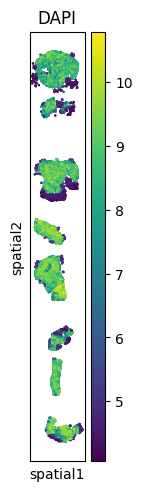

In [11]:
sq.pl.spatial_scatter(
    adata_s1_c1,
    color="DAPI",
    shape=None,
    size=2,
)

In [13]:
adata_core_1= adata_s1_c1[adata_s1_c1.obs['core_ID']=='X1Y1'].copy()

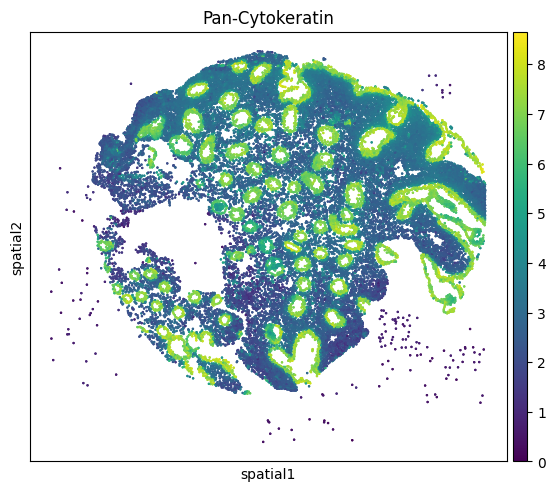

In [132]:
sq.pl.spatial_scatter(
    adata_core_1,
    color="Pan-Cytokeratin",
    shape=None,
    size=2,
    save = '_spatial_codex_s1_core_1'
)

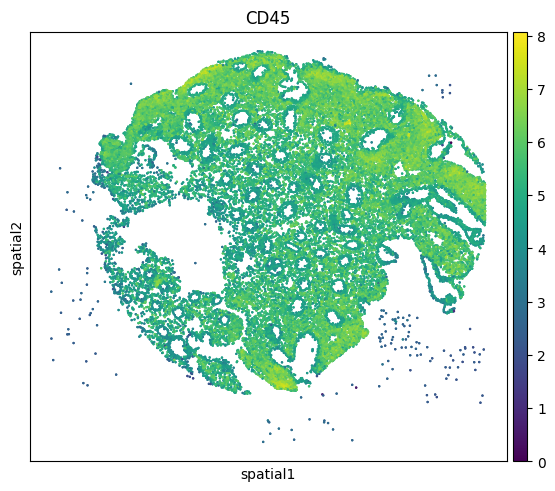

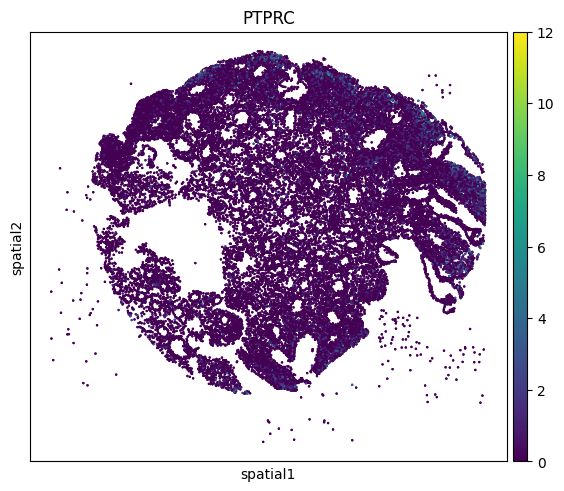

In [15]:
sq.pl.spatial_scatter(
    adata_core_1,
    color="CD45",
    shape=None,
    size=2,
)
sq.pl.spatial_scatter(
    adata_core_1,
    color="PTPRC",
    shape=None,
    size=2,
)

## Add annotation

In [38]:
adata_lisa_annotation = ad.read_h5ad('/media/Lisa/Projects/IBD001/Xenium/Moor0022/Run2/projects/p35688/20250117__150521__o37013-1-2/adata_both_slides_filtered_norm100_log_umap_leiden_corrected.h5ad')

In [27]:
adata_lisa_annotation

AnnData object with n_obs × n_vars = 902860 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Rename cell_ids with slide and column info

In [39]:
column_prefix_map = {
    'column_0': 'col1',
    'column_1': 'col2',
    'column_2': 'col3',
    'column_3': 'col4'
}

# Apply the prefix to each cell_id based on its column
adata_lisa_annotation.obs['cell_id'] = adata_lisa_annotation.obs.apply(
    lambda row: f"{column_prefix_map[row['column']]}_{row['cell_id']}",
    axis=1
)

In [40]:
adata_lisa_annotation.obs['slide_str'] = adata_lisa_annotation.obs['slide_ID'].astype(str).str.replace('.0$', '', regex=True)
adata_lisa_annotation.obs['cell_id'] = adata_lisa_annotation.obs['slide_str'] + '_' + adata_lisa_annotation.obs['cell_id'].astype(str)

In [42]:
full_adata.obs = full_adata.obs.set_index('cell_id')
adata_lisa_annotation.obs = adata_lisa_annotation.obs.set_index('cell_id')

In [43]:
# Keep only the cell_ids in df
valid_cell_ids = adata_lisa_annotation.obs.index.intersection(full_adata.obs.index)

# Subset the entire AnnData object (not just .obs!)
full_adata = full_adata[valid_cell_ids].copy()

In [44]:
full_adata

AnnData object with n_obs × n_vars = 902859 × 422
    obs: 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'slide'
    obsm: 'spatial'

### Merge filtered, annotated Xenium adata with the full integrated adata

In [45]:
full_adata.obs = full_adata.obs.join(adata_lisa_annotation.obs, how='left', rsuffix='_merged')

In [46]:
cols_to_drop = [col for col in full_adata.obs.columns if col.endswith('_merged')]
full_adata.obs.drop(columns=cols_to_drop, inplace=True)

In [47]:
# Optionally, reset index to get 'cell_id' back as a column
full_adata.obs = full_adata.obs.reset_index()

In [49]:
full_adata

AnnData object with n_obs × n_vars = 902859 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden'
    obsm: 'spatial'

### Assign cluster names

In [51]:
annotation_dict = {
    "0": "T cells",
    "1": "inflammatory fibroblasts",
    "2": "Plasma Cells",
    "3": "M2 macrophages",
    "4": "Pericytes/Fibroblasts",
    "5": "Goble-like (Crypts)",
    "6": "Neutrophils",
    "7": "B cells",
    "8": "Goblet cells (ileum)",
    "9": "Goblet cells (colon)",
    "10": "Enterocytes",
    "11": "Colonocytes",
    "12": "Myofibroblasts",
    "13": "Possible LND cells (Enterocytes)",
    "14": "Activated fibroblasts or mesenchymal cells",
    "15": "Mast Cells",
    "16": "Immune cells (non specific)",
    "17": "B cells",
    "18": "Smooth Muscle Cells",
    "19": "Dendritic Cells/Myeloid Cells/Macrophages",
    "20": "Activated smooth muscle cells/stromal/endothelial cells",
    "21": "Immune cells (non specific)",
    "22": "Ig-Secreting Plasma Cells",
    "23": "Ig-Secreting Plasma Cells",
    "24": "Ig-Secreting Plasma Cells",
    "25": "Activated Fibroblasts (Myofibroblasts)/Smooth Muscle Cells",
    "26": "Fibroblasts/Mesenchymal Cells",
    "27": "T Cells",
    "28": "Macrophages/Eosinophils",
    "29": "Stromal/Endothelial/Mesenchymal",
    "30": "Macrophages/Neutrophils",
    "31": "Plasma/B cells",
    "32": "Plasma/B cells",
    "33": "Plasma/B cells"
}

# Map string-based 'leiden' clusters to annotations
full_adata.obs['annotation'] = full_adata.obs['leiden'].map(annotation_dict)

### Manually add back the .obsm, .var etc from Lisa's adata to the integrated one

In [73]:
# Copy var (gene metadata)
full_adata.var = adata_lisa_annotation.var.copy()

# Copy uns (unstructured annotation, e.g., leiden, neighbors info)
full_adata.uns = adata_lisa_annotation.uns.copy()

# Copy obsm (embeddings like PCA, UMAP, spatial)
full_adata.obsm = adata_lisa_annotation.obsm.copy()

# Copy varm (loadings, e.g. PCs)
full_adata.varm = adata_lisa_annotation.varm.copy()

# Copy layers (e.g. counts)
full_adata.layers = adata_lisa_annotation.layers.copy()

# Copy obsp (neighbor graphs)
full_adata.obsp = adata_lisa_annotation.obsp.copy()

In [75]:
full_adata

AnnData object with n_obs × n_vars = 902859 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_b

### Save new annotated adata

In [78]:
output_path = "/media/Lynn/data/Integrated_data/adata_filtered_merged_both_slides_codex_log1p_xenium_norm100_log_umap_leiden.h5ad"
full_adata.write(output_path)

## Plot each CODEX channel intensity per cell type

In [67]:
full_adata = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata_filtered_merged_both_slides_codex_log1p_xenium_norm100_log_umap_leiden.h5ad")

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


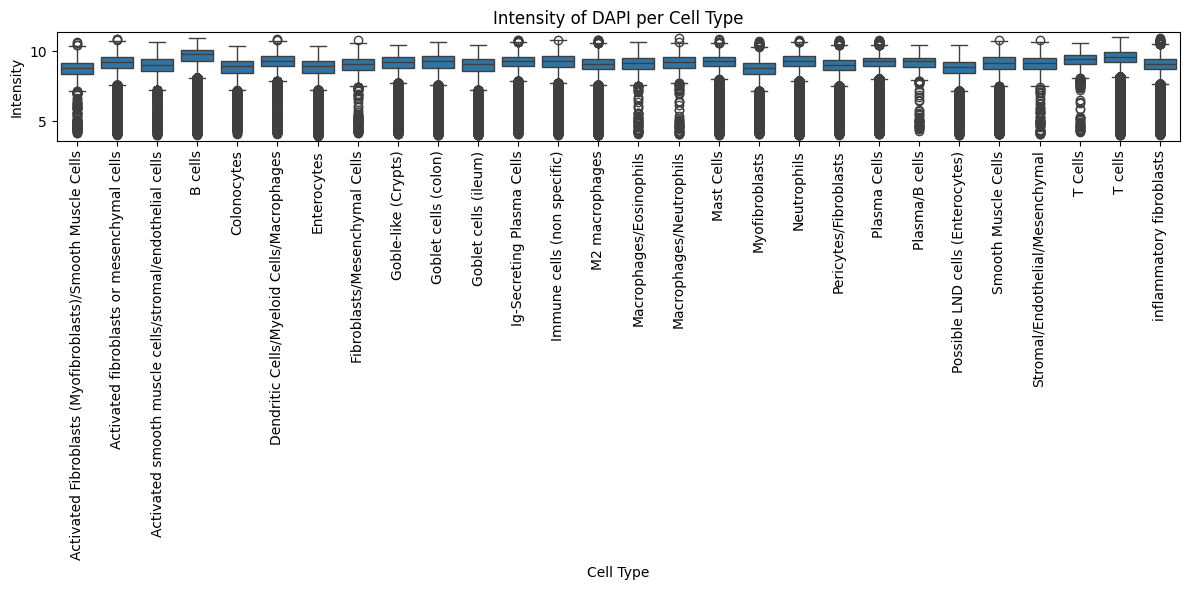

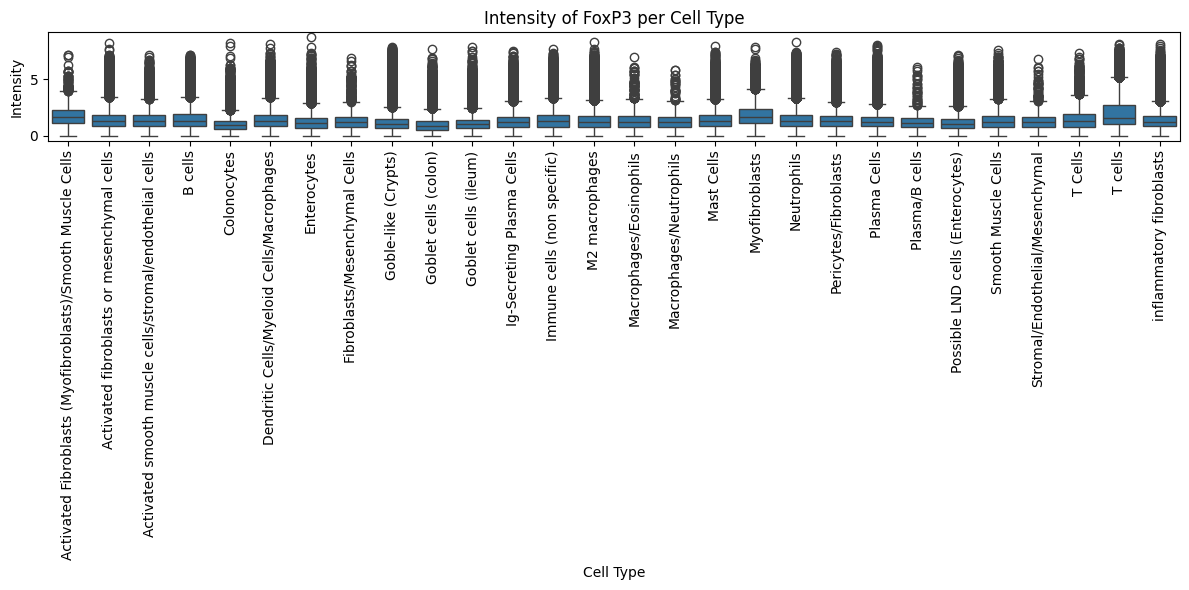

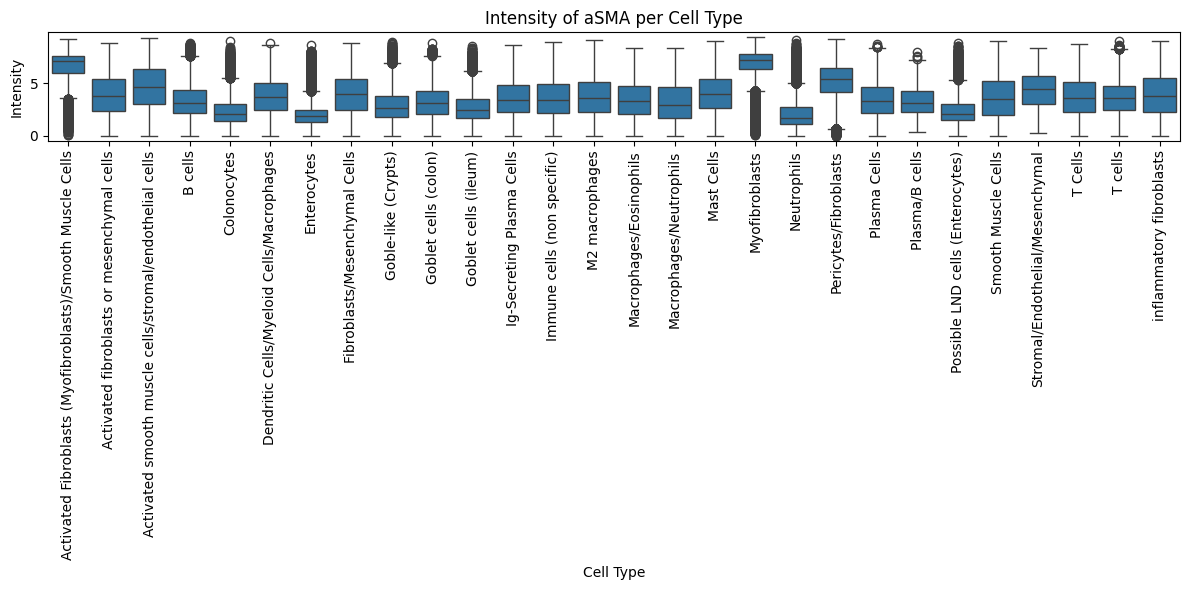

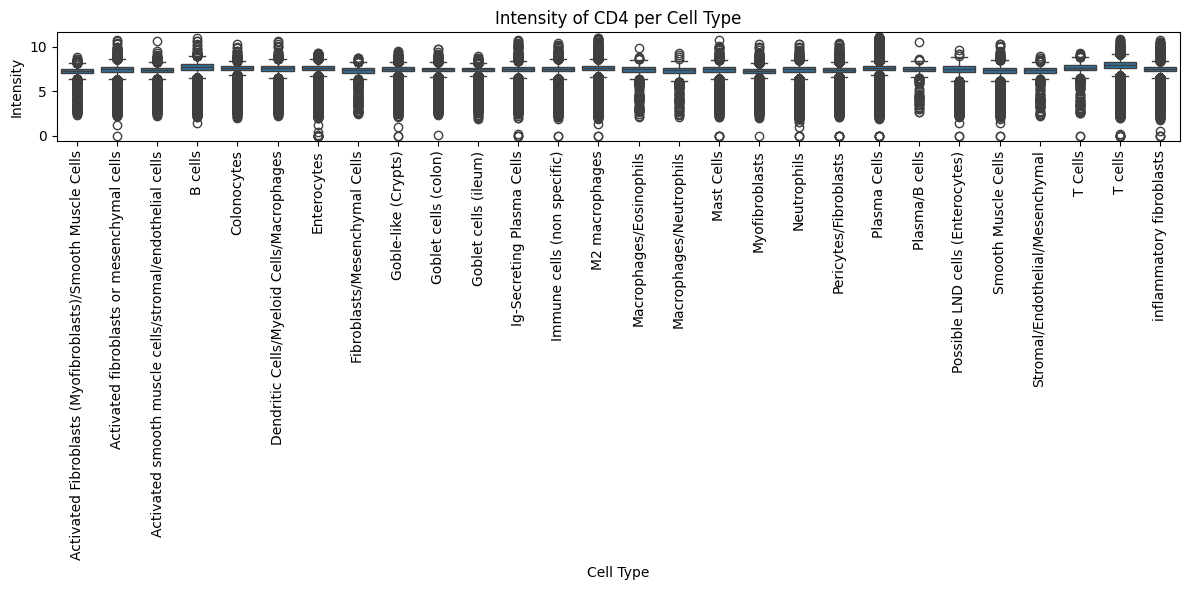

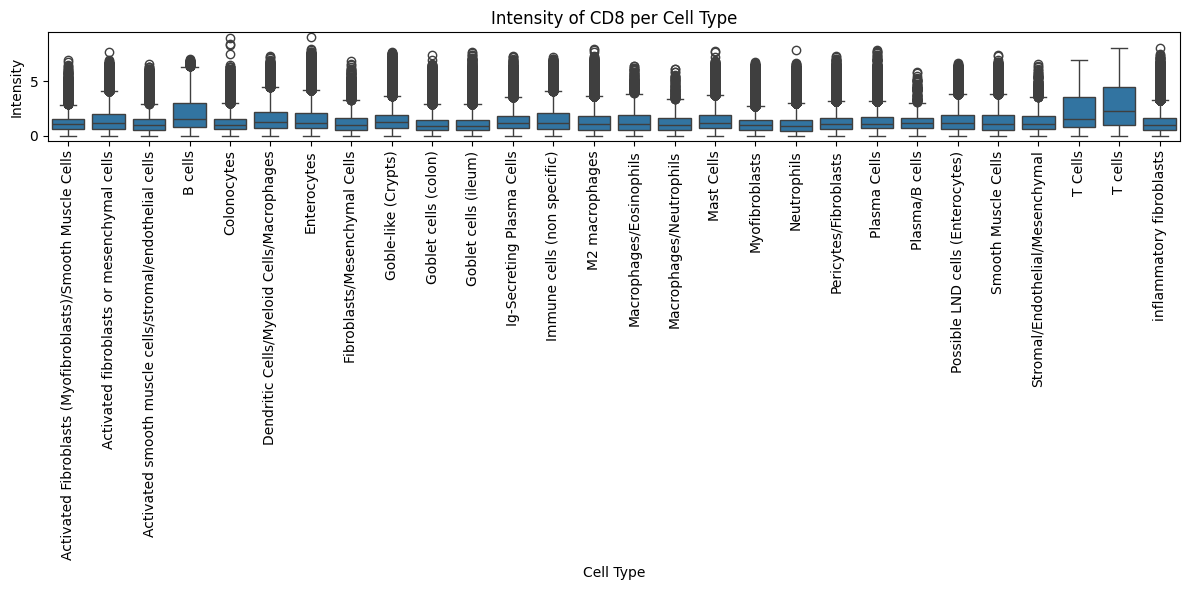

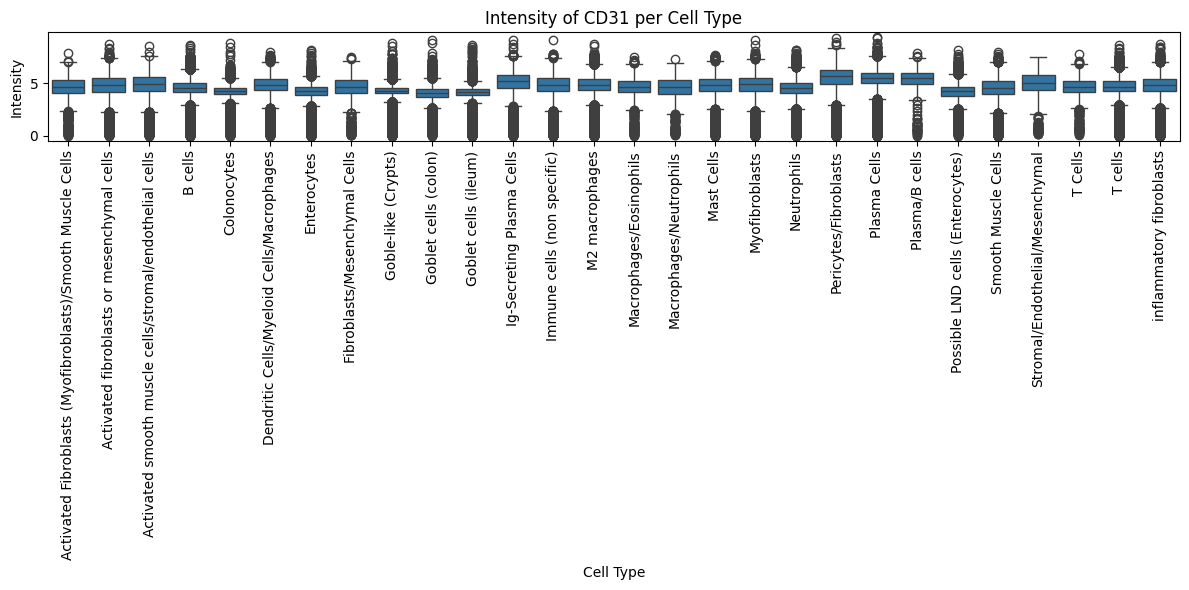

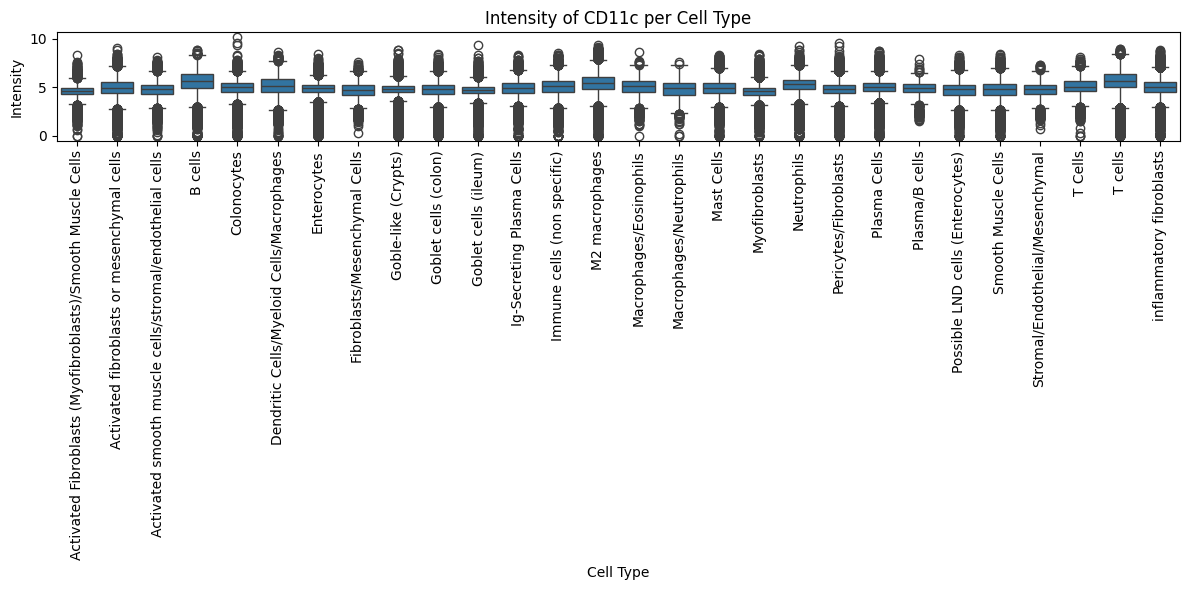

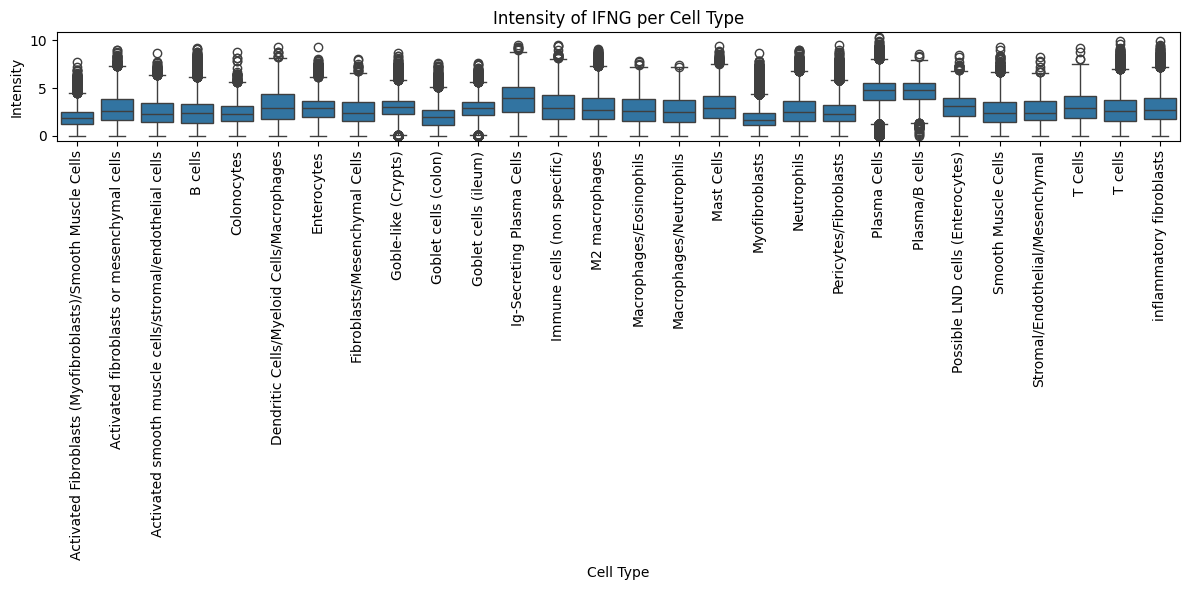

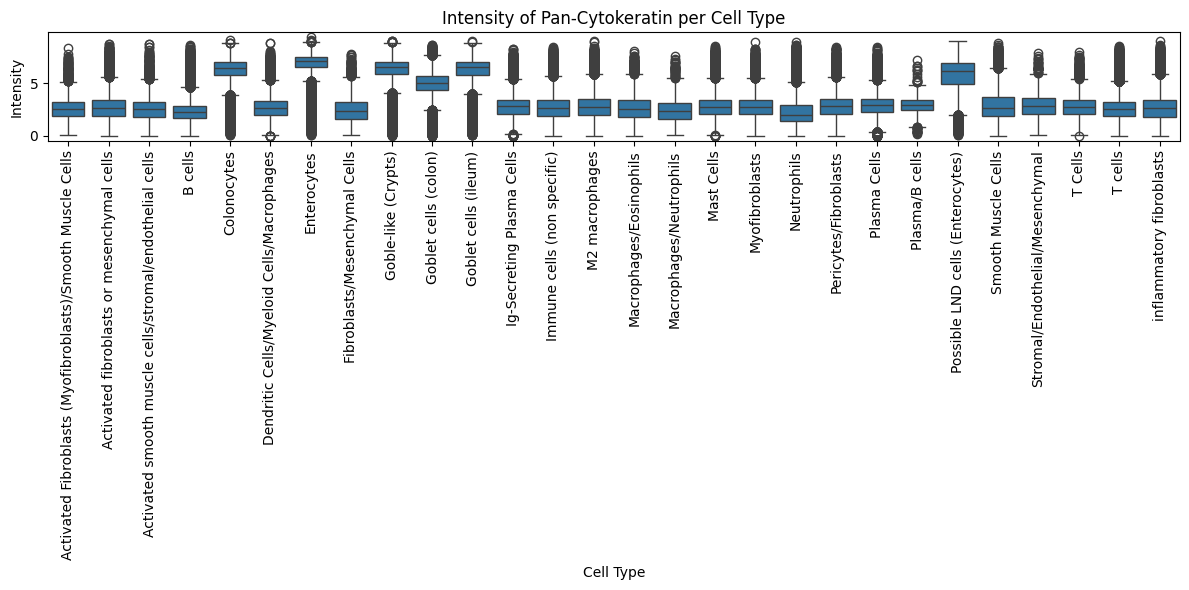

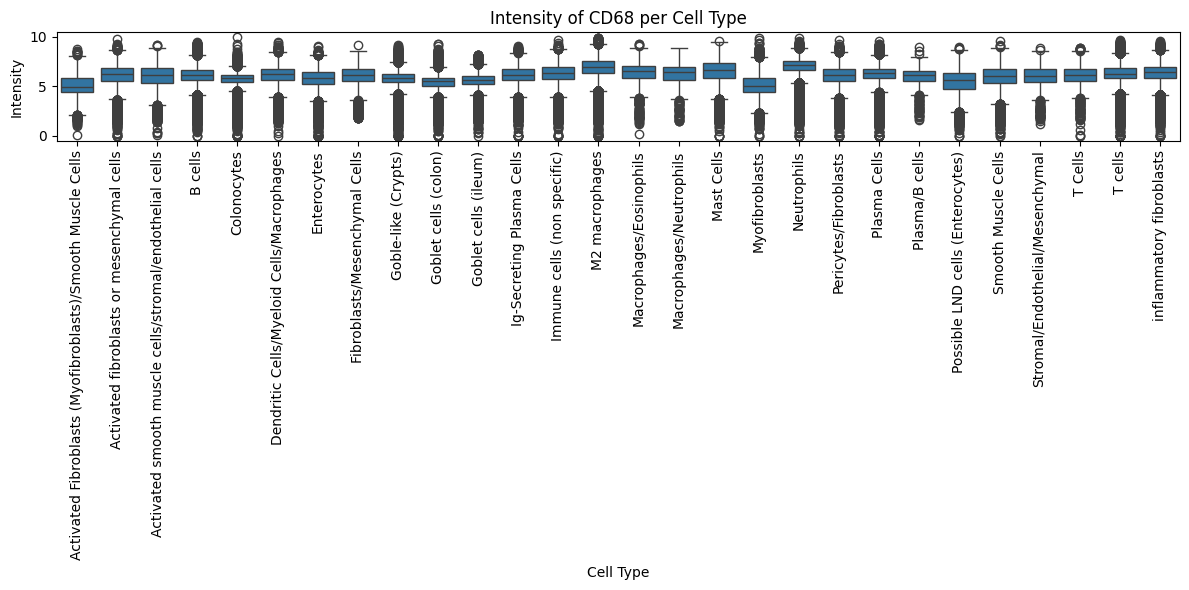

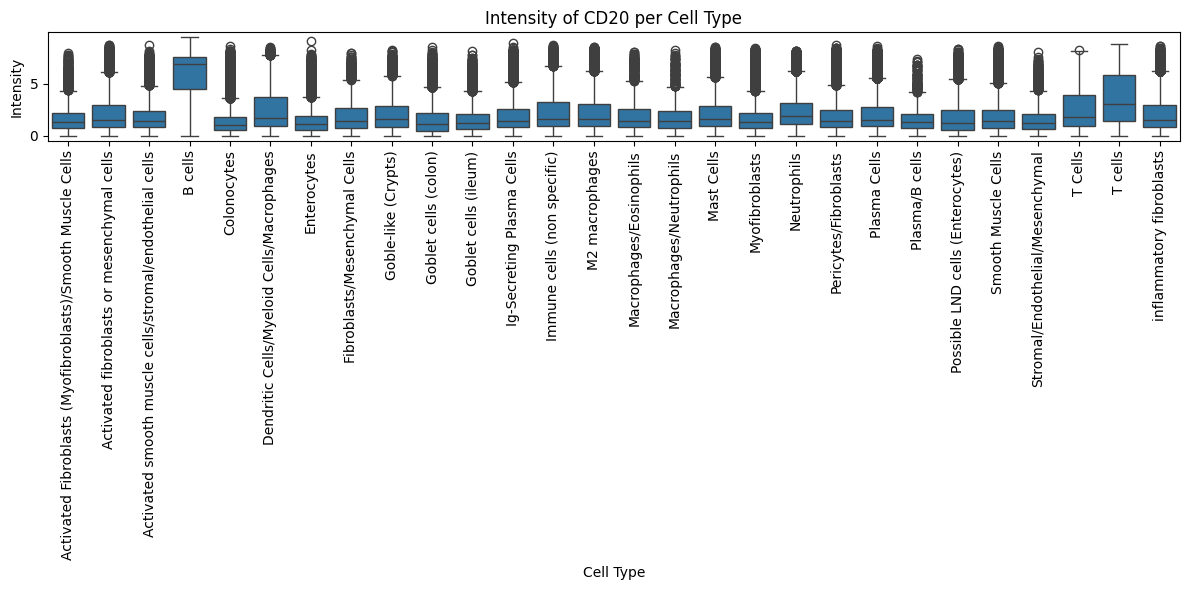

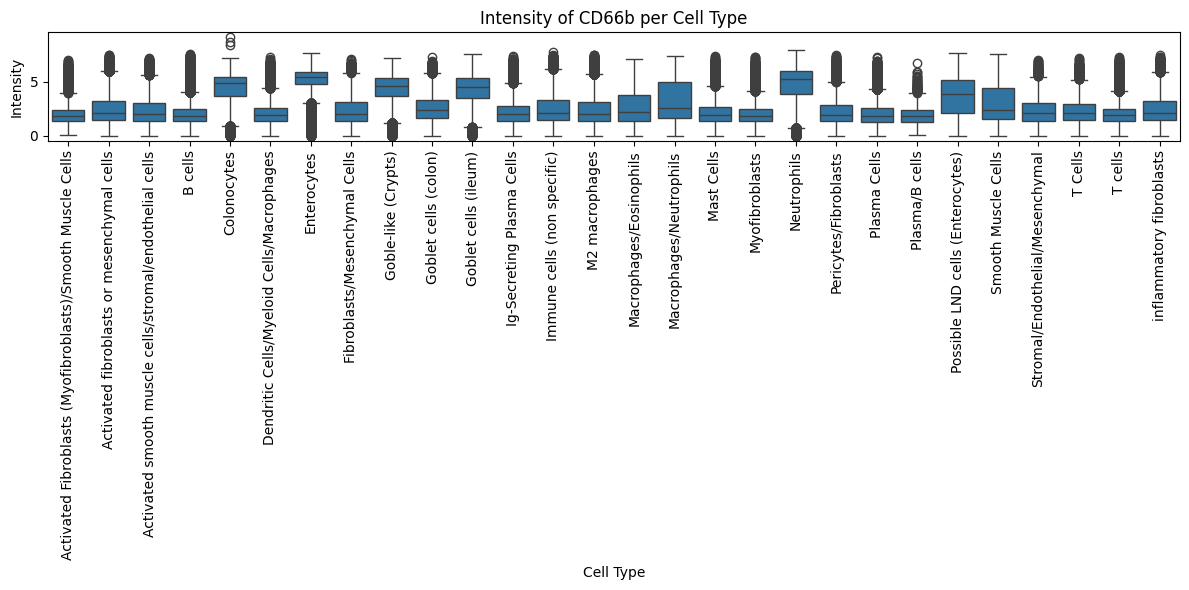

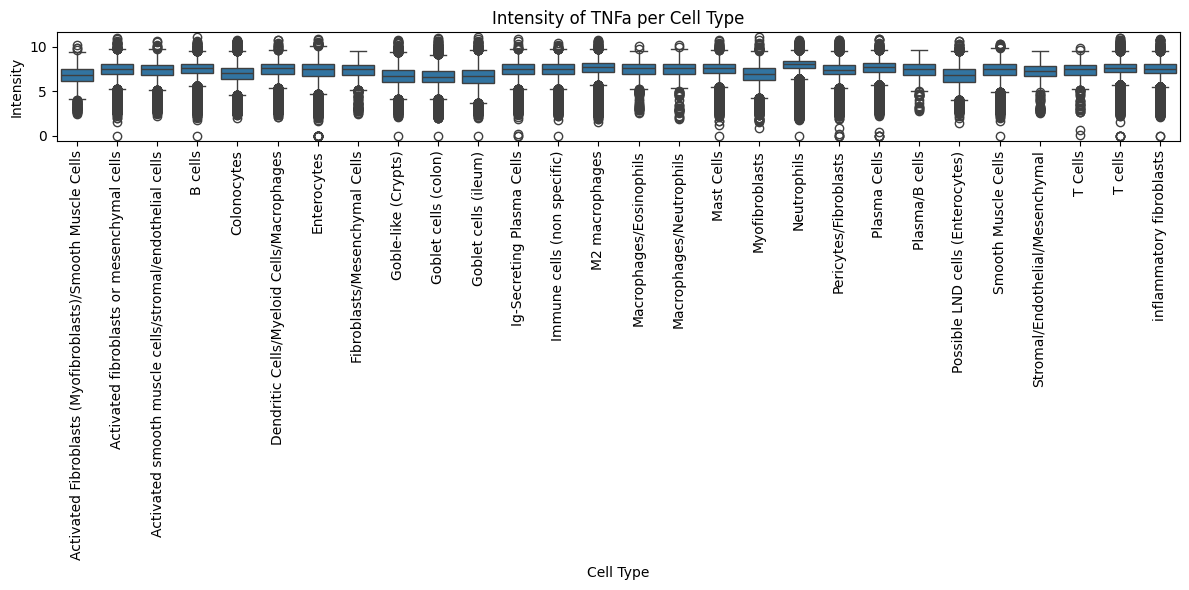

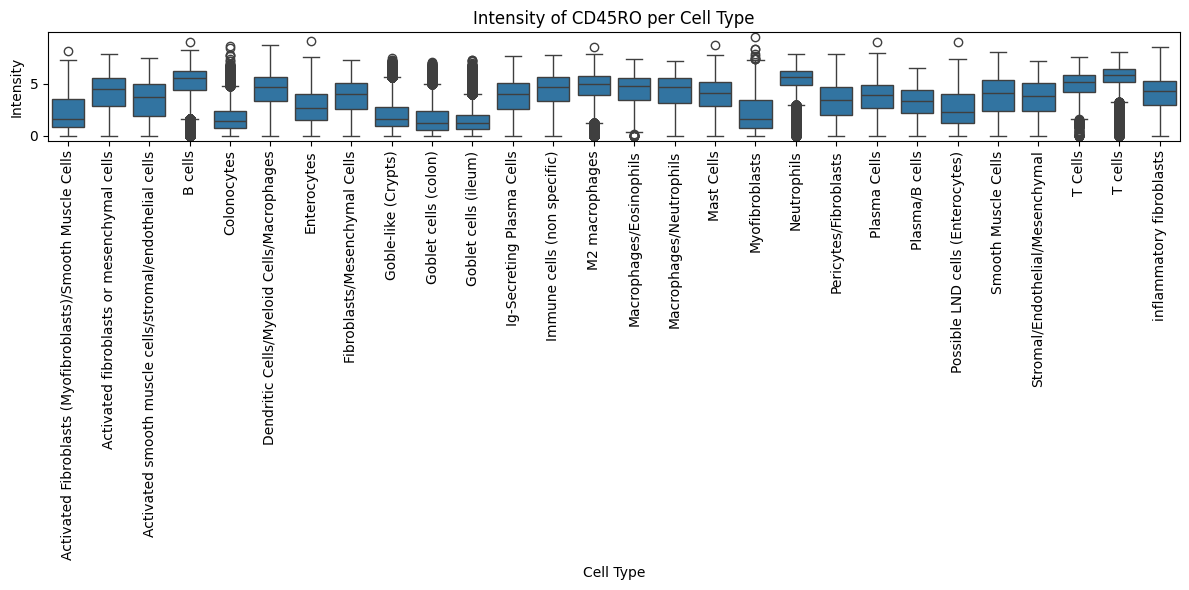

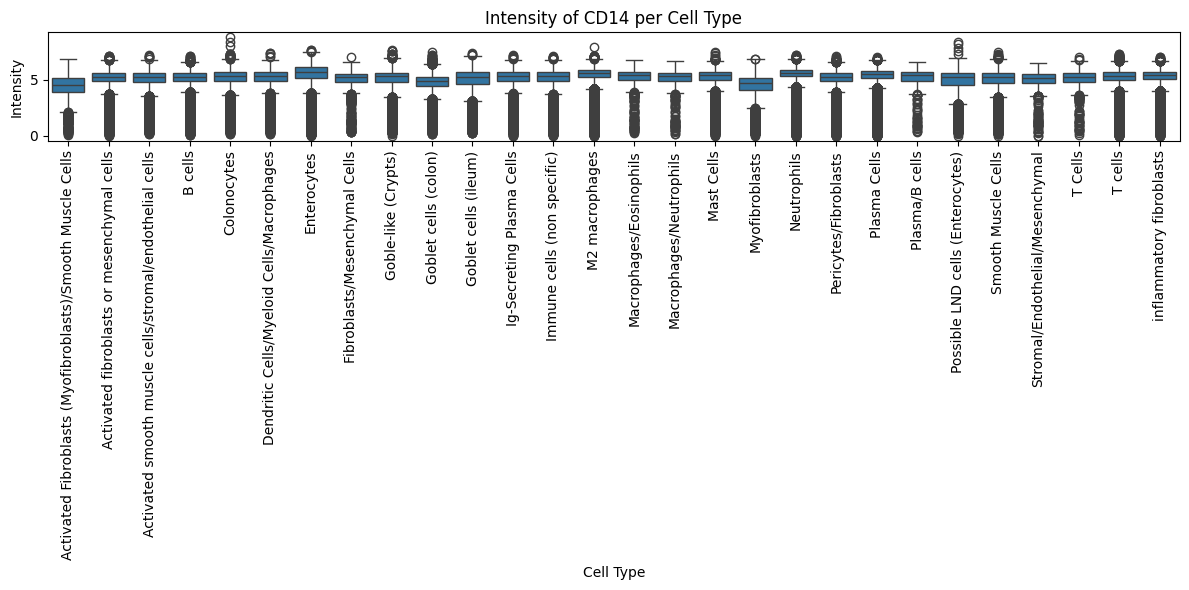

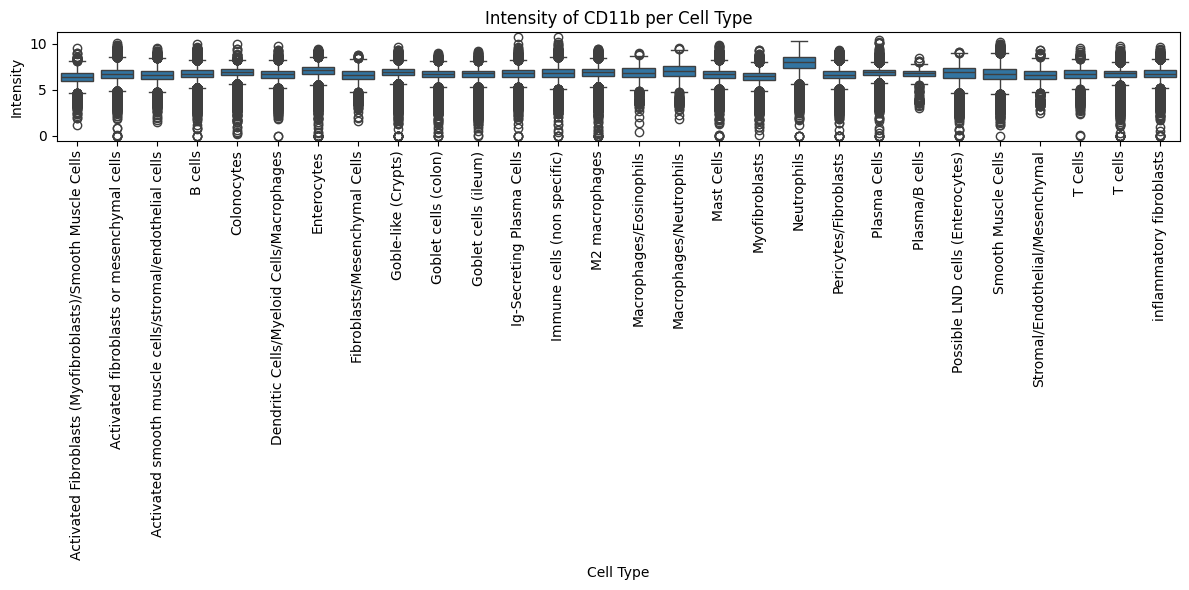

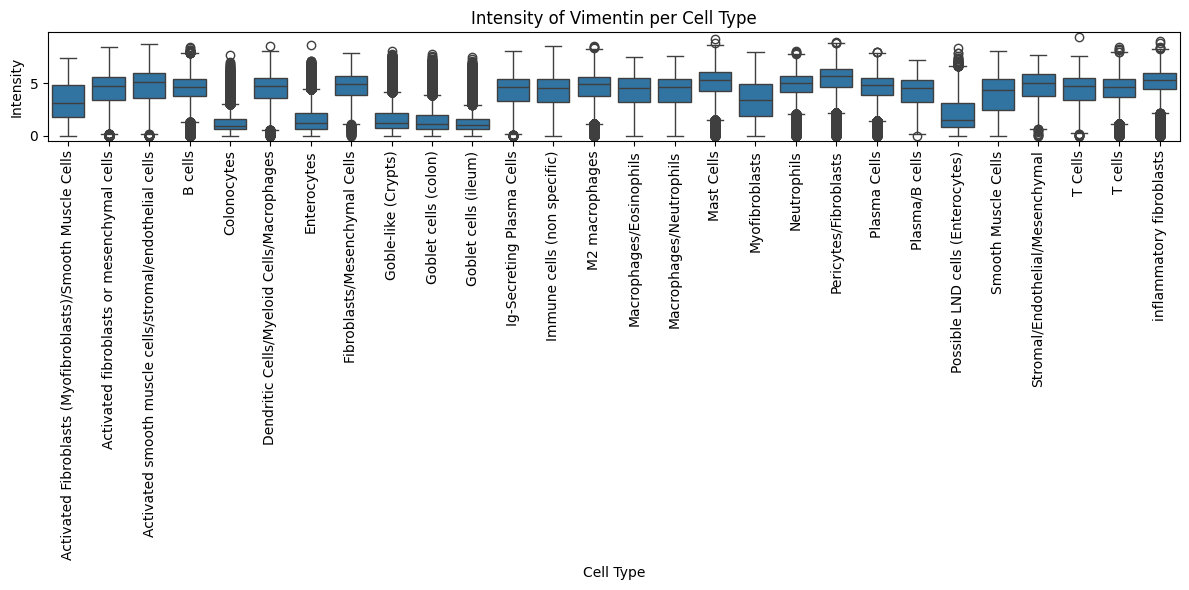

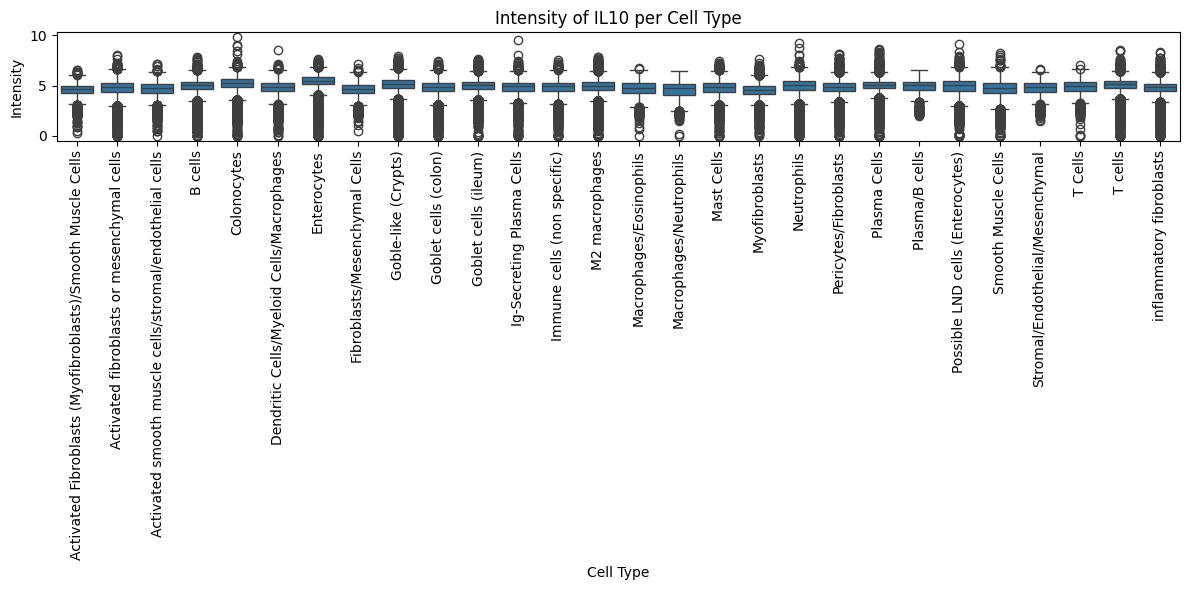

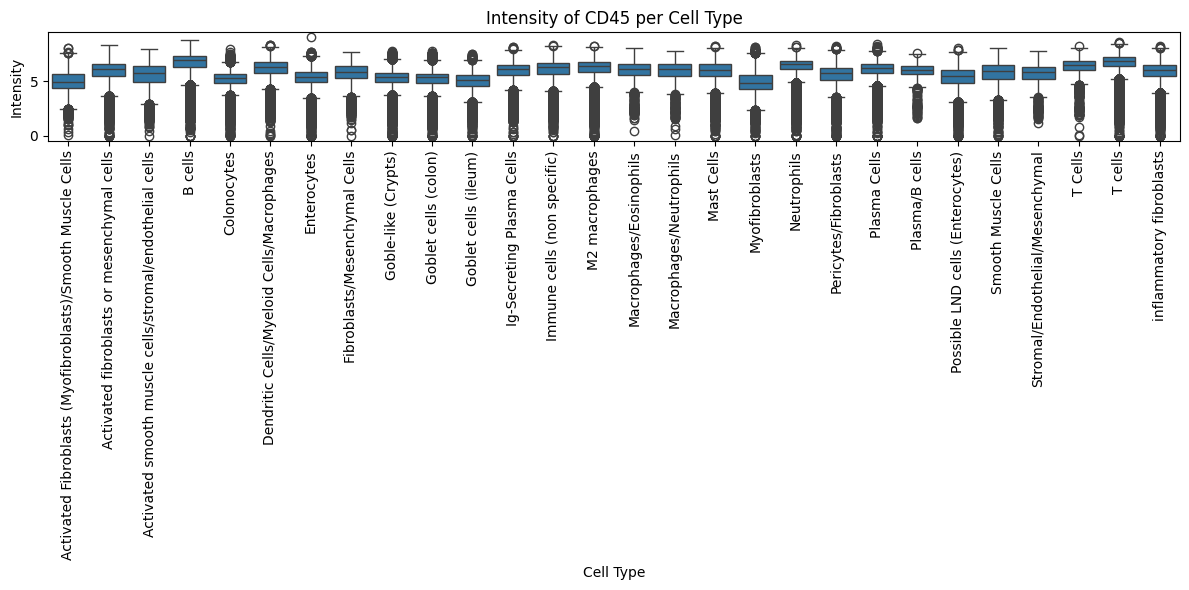

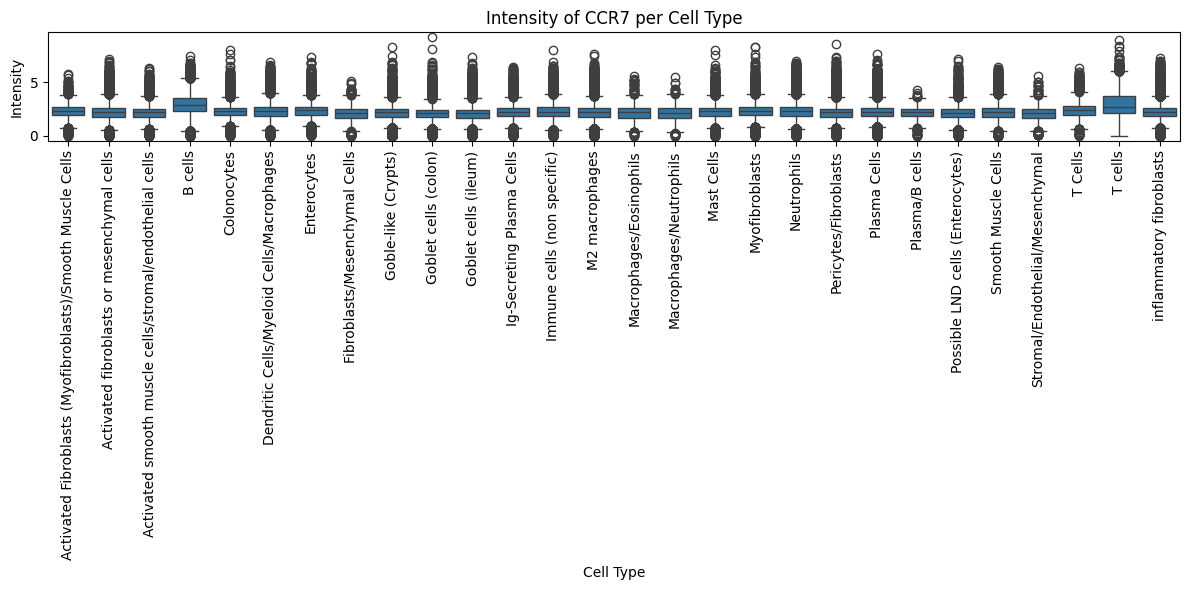

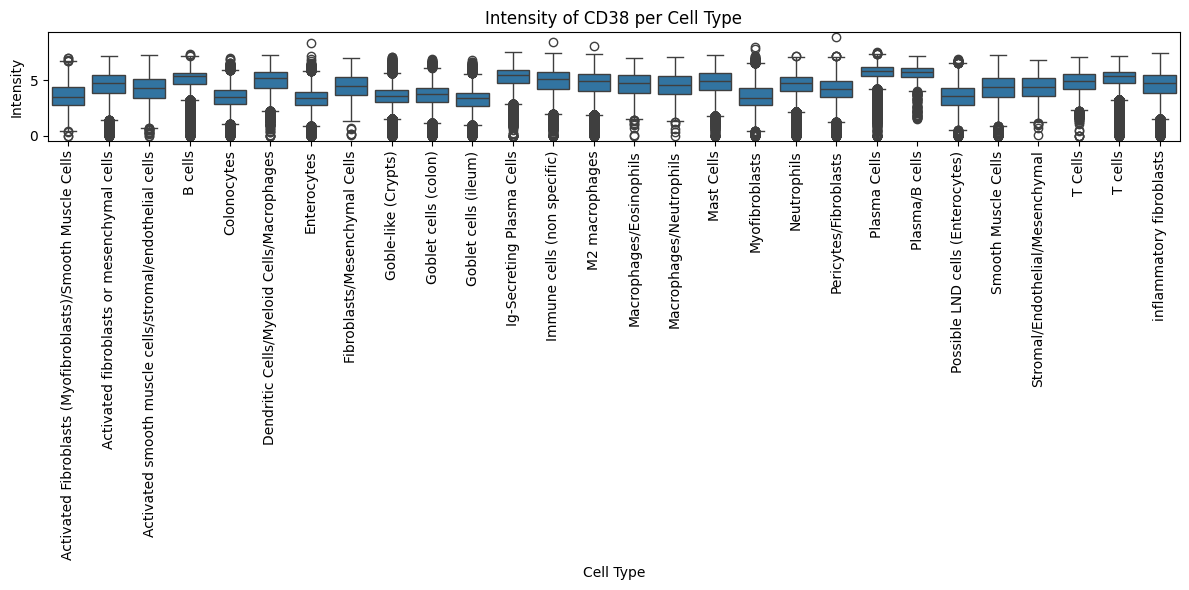

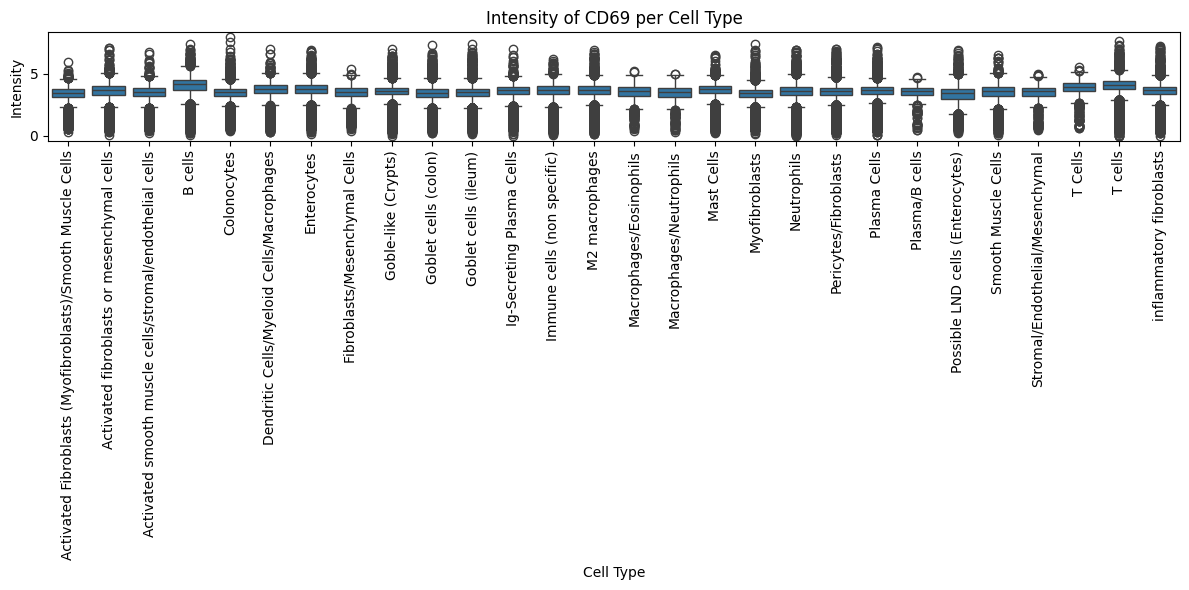

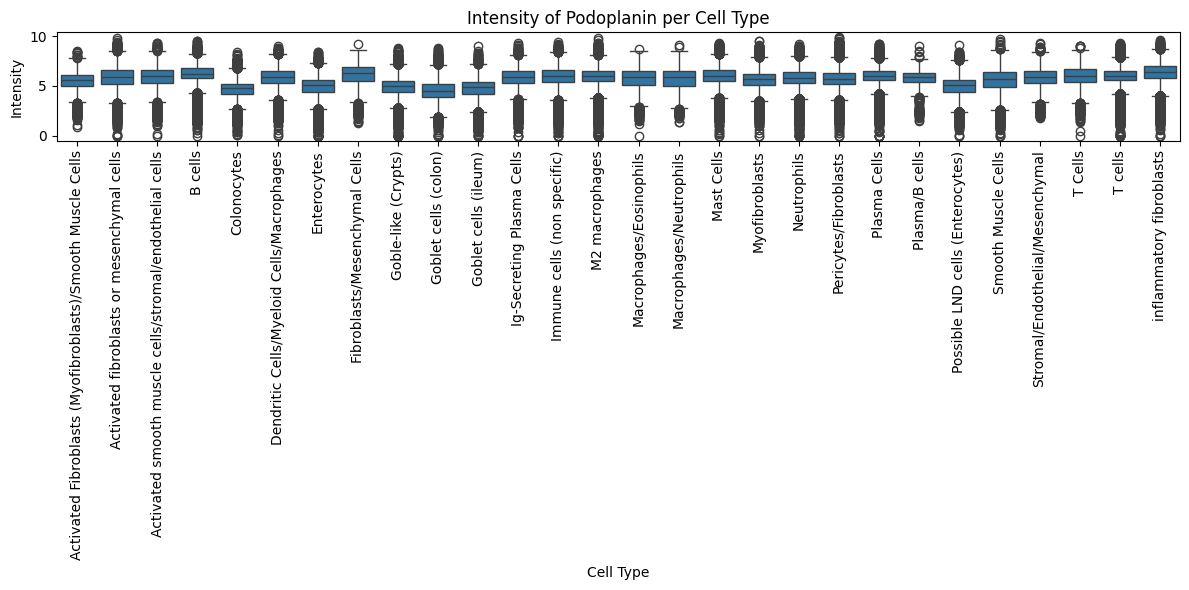

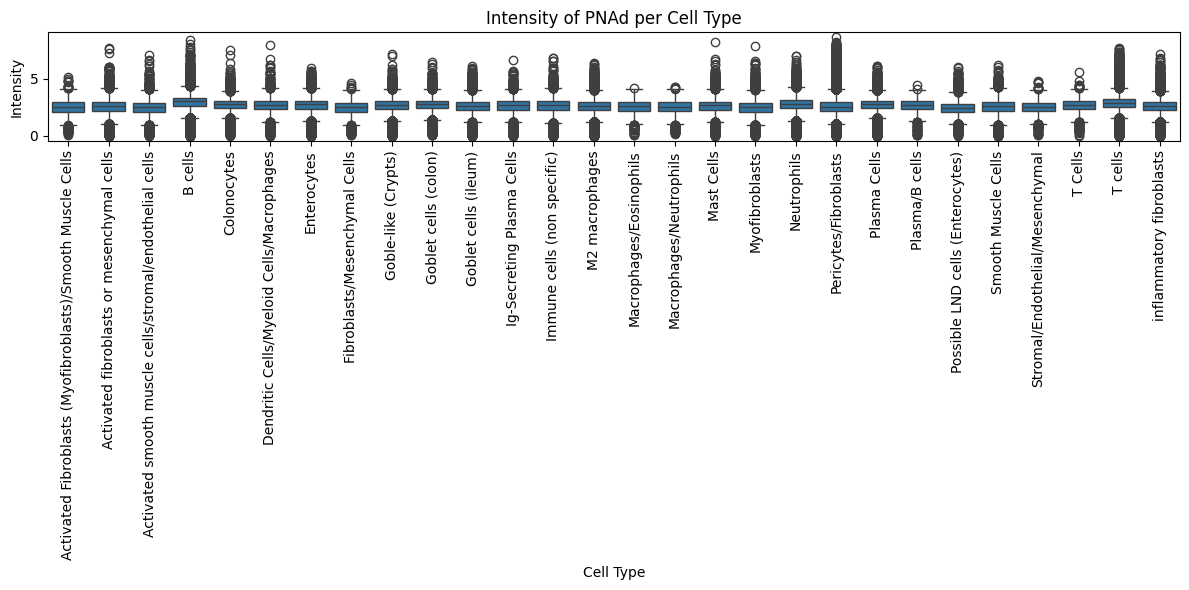

In [63]:
# Create output directory for plots if it doesn't exist
output_dir = "marker_intensity_plots"
os.makedirs(output_dir, exist_ok=True)

# Extract obs data with annotations and CODEX intensities
df_plot = full_adata.obs[codex_channels + ['annotation']].copy()

for channel in codex_channels:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_plot, x='annotation', y=channel)
    plt.xticks(rotation=90)
    plt.title(f"Intensity of {channel} per Cell Type")
    plt.ylabel("Intensity")
    plt.xlabel("Cell Type")
    plt.tight_layout()
    
    # Save the plot
    filename = f"{channel}_intensity_boxplot.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    print(f"Saved plot for {channel} to: {filepath}")

print(f"\nAll plots saved to directory: {output_dir}")

### Normalize everything then check top markers per cell type

In [140]:
# Remove DAPI from the list of channels
codex_channels_no_dapi = [ch for ch in codex_channels if ch != 'DAPI']

# Group by cell type and compute mean intensity of each marker
mean_per_annotation = full_adata.obs.groupby('annotation')[codex_channels_no_dapi].mean()

# Normalization step: Z-score normalization across cell types for each marker
# This makes markers comparable by standardizing their scale
normalized_mean_per_annotation = mean_per_annotation.copy()
for marker in codex_channels_no_dapi:
    marker_values = mean_per_annotation[marker]
    normalized_mean_per_annotation[marker] = (marker_values - marker_values.mean()) / marker_values.std()

# For each cell type, get the top 5 markers sorted by normalized mean intensity
top5_markers_per_type = normalized_mean_per_annotation.apply(
    lambda row: row.sort_values(ascending=False).head(5).index.tolist(), axis=1
)
top5_normalized_values_per_type = normalized_mean_per_annotation.apply(
    lambda row: row.sort_values(ascending=False).head(5).values.tolist(), axis=1
)

# Also keep the original values for reference
top5_original_values_per_type = mean_per_annotation.apply(
    lambda row: row[top5_markers_per_type[row.name]].values.tolist(), axis=1
)

# Combine into a summary DataFrame
top5_summary = pd.DataFrame({
    'Top 5 Markers': top5_markers_per_type,
    'Top 5 Normalized Values': top5_normalized_values_per_type,
    'Top 5 Original Values': top5_original_values_per_type
})

# Optional: sort alphabetically by cell type
top5_summary = top5_summary.sort_index()

# Display
print("Top 5 markers per cell type in order (1->5, based on z-normalized intensities):")
print(top5_summary)

Top 5 markers per cell type in order (1->5, based on z-normalized intensities):
                                                                                  Top 5 Markers  \
annotation                                                                                        
Activated Fibroblasts (Myofibroblasts)/Smooth M...        [aSMA, FoxP3, CCR7, CD31, Podoplanin]   
Activated fibroblasts or mesenchymal cells          [FoxP3, CD45RO, Vimentin, Podoplanin, TNFa]   
Activated smooth muscle cells/stromal/endotheli...     [aSMA, Vimentin, CD31, Podoplanin, TNFa]   
B cells                                                         [CD20, CCR7, PNAd, CD69, CD11c]   
Colonocytes                                           [Pan-Cytokeratin, CD66b, IL10, PNAd, CD4]   
Dendritic Cells/Myeloid Cells/Macrophages                     [CD11c, CD38, CD45, CD45RO, CD69]   
Enterocytes                                         [IL10, CD66b, Pan-Cytokeratin, CD14, CD11b]   
Fibroblasts/Mesenchymal Cells

/tmp/ipykernel_84262/3176890080.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_per_annotation = full_adata.obs.groupby('annotation')[codex_channels_no_dapi].mean()


## Plot each CODEX channel intensity per slide

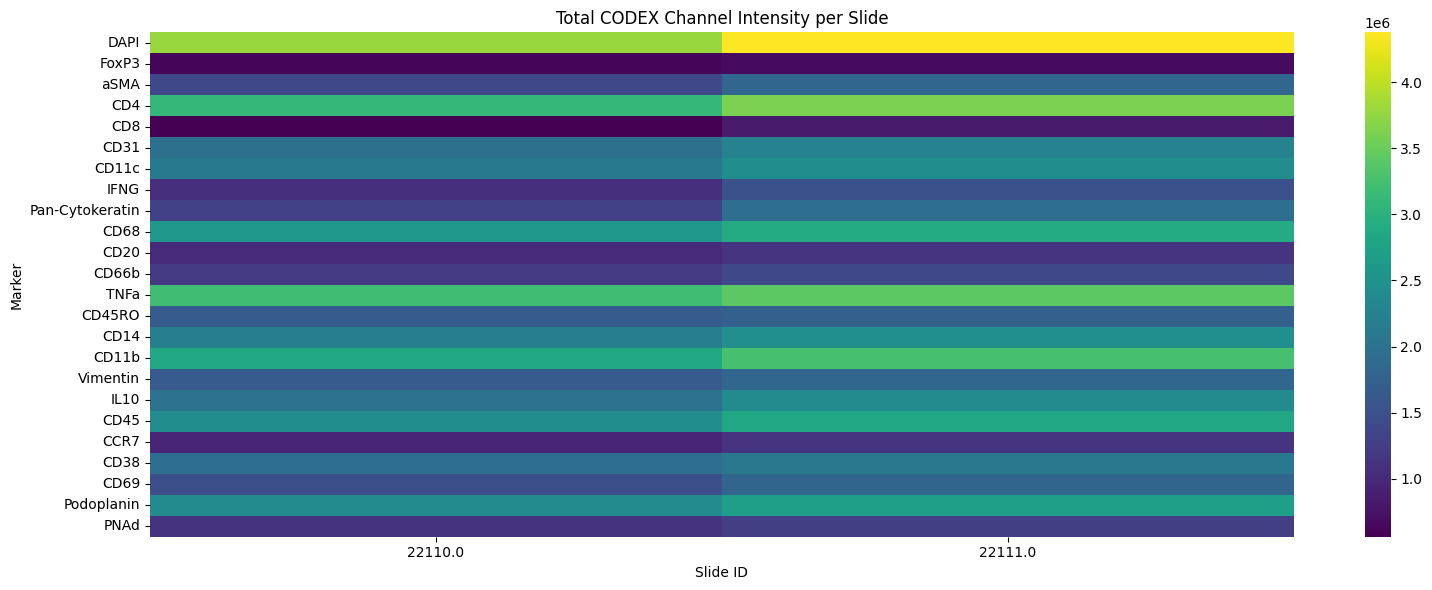

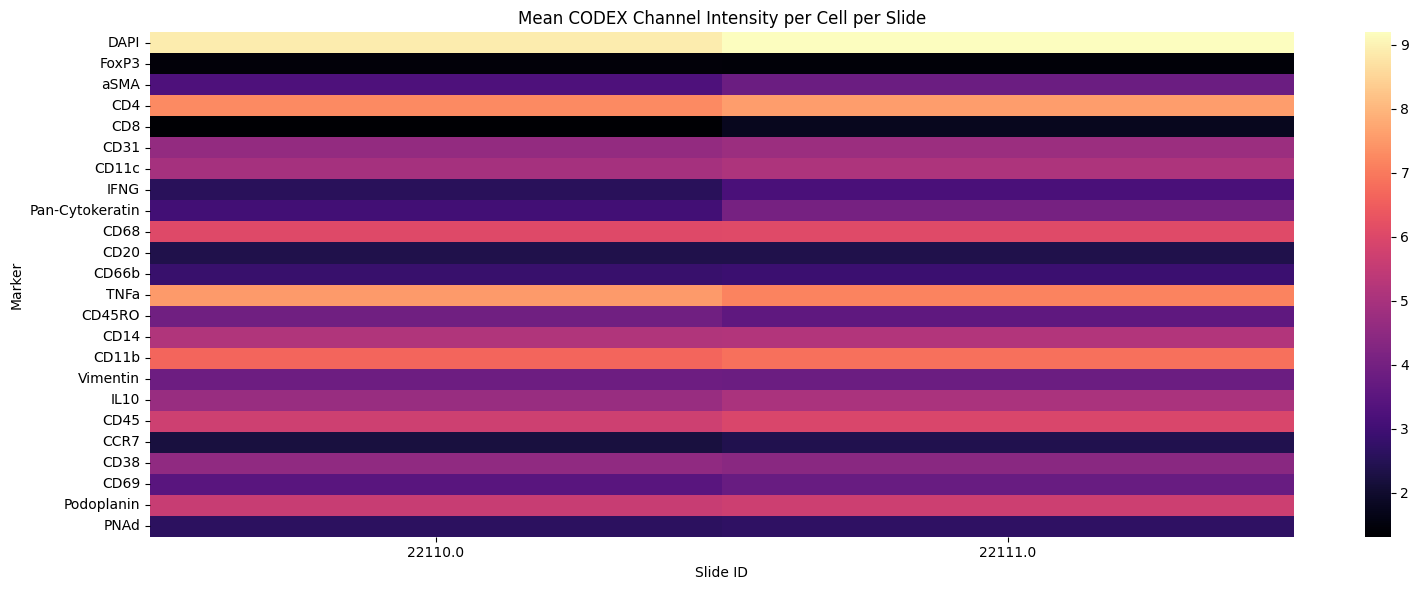

In [59]:
# Create DataFrame from obs
df = full_adata.obs[codex_channels + ['slide_ID']].copy()

# 1. Total intensity per slide (sum of each channel)
intensity_sum = df.groupby('slide_ID')[codex_channels].sum()

# 2. Normalized intensity (mean per cell)
intensity_mean = df.groupby('slide_ID')[codex_channels].mean()

# Plot total intensity per slide
plt.figure(figsize=(16, 6))
sns.heatmap(intensity_sum.T, cmap='viridis')
plt.title("Total CODEX Channel Intensity per Slide")
plt.xlabel("Slide ID")
plt.ylabel("Marker")
plt.tight_layout()
plt.show()

# Plot normalized (mean) intensity per slide
plt.figure(figsize=(16, 6))
sns.heatmap(intensity_mean.T, cmap='magma')
plt.title("Mean CODEX Channel Intensity per Cell per Slide")
plt.xlabel("Slide ID")
plt.ylabel("Marker")
plt.tight_layout()
plt.show()

In [61]:
slide_1 = 22110
slide_2 = 22111

# Get the mean intensities for those slides
mean_1 = intensity_mean.loc[slide_1]
mean_2 = intensity_mean.loc[slide_2]

# Compute absolute differences
diff = (mean_1 - mean_2).abs().sort_values(ascending=False)

# Show top markers
print("Top markers with highest mean intensity differences between the two slides:")
print(diff.head(10))


Top markers with highest mean intensity differences between the two slides:
Pan-Cytokeratin    1.017413
IFNG               0.594611
aSMA               0.572392
CD8                0.454056
TNFa               0.360784
IL10               0.323532
CD69               0.317441
CD4                0.314730
CD45RO             0.308944
DAPI               0.287971
dtype: float64


## Xenium Clustering

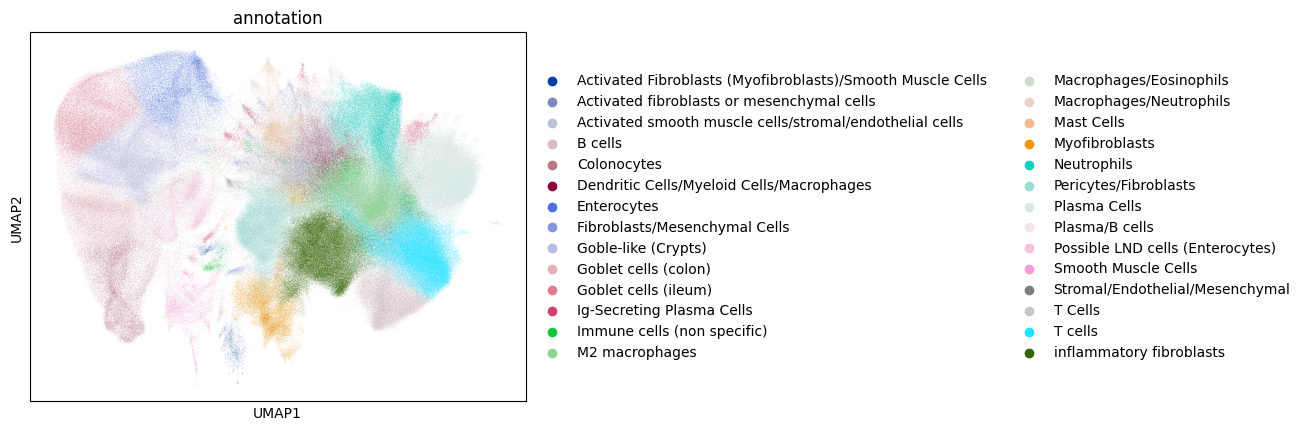

In [77]:
sc.pl.umap(full_adata, color="annotation")

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/squidpy/pl/_utils.py:95: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(path, **kwargs)
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, *

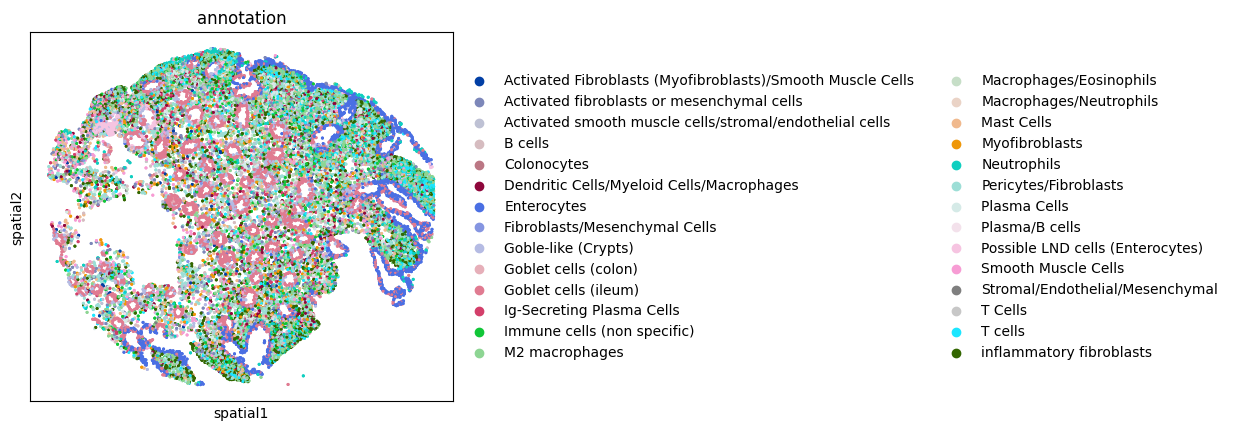

In [80]:
adata_s1_c1 = full_adata[(full_adata.obs['core_ID']=='X1Y1') & (full_adata.obs['slide_ID']==22110) ].copy()

sq.pl.spatial_scatter(
    adata_s1_c1,
    library_id="spatial",
    shape=None,
    color=[
        "annotation",
    ],
    wspace=0.4,
    save = '_spatial__xenium_22110_X1Y1_with_metadata_res_1.png'
)

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/squidpy/pl/_utils.py:95: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(path, **kwargs)
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, *

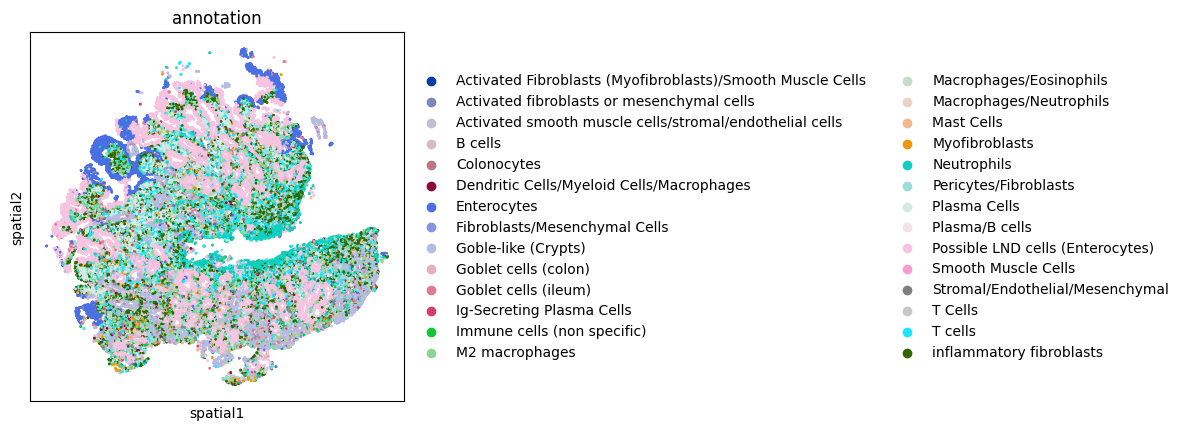

In [81]:
adata_s2_c4 = full_adata[(full_adata.obs['core_ID']=='X4Y2')& (full_adata.obs['slide_ID']==22111)].copy()

sq.pl.spatial_scatter(
    adata_s2_c4,
    library_id="spatial",
    shape=None,
    color=[
        "annotation",
    ],
    wspace=0.4,
    save = '_spatial__xenium_22111_X4Y2_with_metadata_res_1.png'
)

In [119]:
colon_goblet = adata_s2_c4[(adata_s2_c4.obs['annotation']=='Goblet cells (colon)')]

In [138]:
colon_goblet

View of AnnData object with n_obs × n_vars = 164 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_drop

In [122]:
colon_ileum = adata_s2_c4[(adata_s2_c4.obs['annotation']=='Goblet cells (ileum)')]
colon_ileum

View of AnnData object with n_obs × n_vars = 265 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_drop

***Does this look correct? Should we just put 'Goblet cells'***

### Per Tissue, Time point, Patient, Year, Core

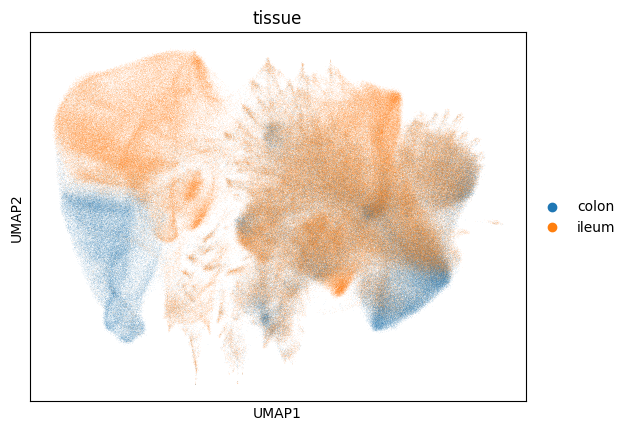

In [82]:
sc.pl.umap(
    full_adata,
    color=[
        "tissue",
    ],
    wspace=0.4,
    save = '_by_tissue_xenium_with_metadata_res_1.png'
)

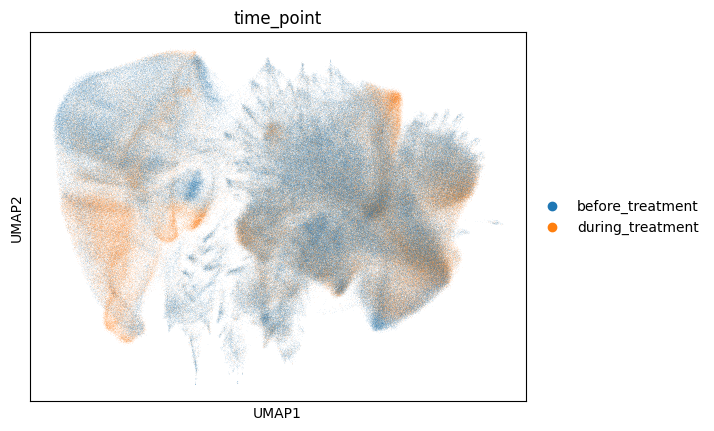

In [83]:
sc.pl.umap(
    full_adata,
    color=[
        "time_point",
    ],
    wspace=0.4,
    save = '_by_timepoint_xenium_with_metadata_res_1.png'
)

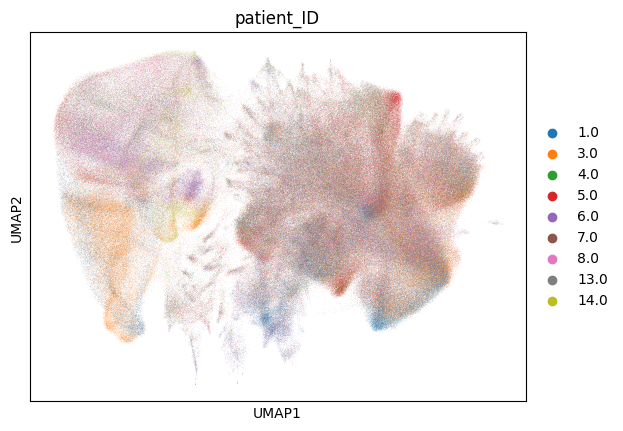

In [86]:
full_adata.obs["patient_ID"] = full_adata.obs["patient_ID"].astype(str) 

sc.pl.umap(
    full_adata,
    color=["patient_ID"],
    wspace=0.4,
    save='_by_patient_xenium_with_metadata_res_1.png'
)

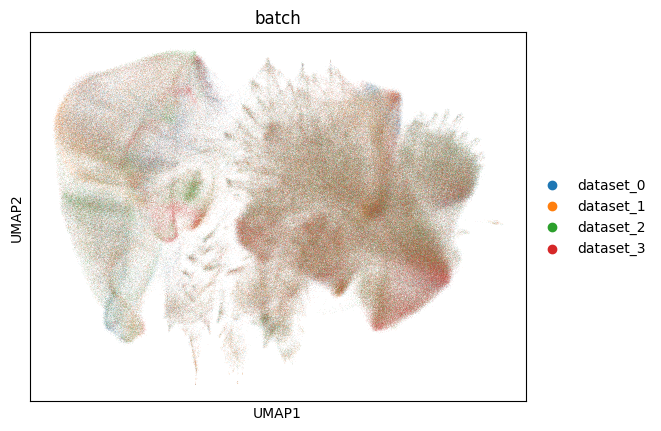

In [85]:
sc.pl.umap(
    full_adata,
    color=[
        "batch",
    ],
    wspace=0.4,
    save = '_by_batch_xenium_with_metadata_res_1.png'
)

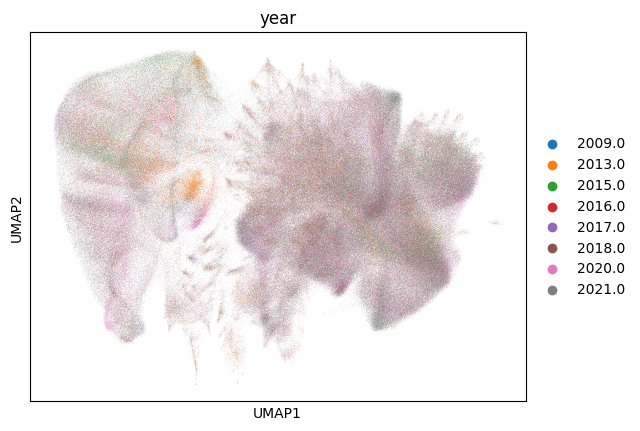

In [87]:
full_adata.obs["year"] = full_adata.obs["year"].astype(str)  

sc.pl.umap(
    full_adata,
    color=["year"],
    wspace=0.4,
    save='_by_year_xenium_with_metadata_res_1.png'
)

In [88]:
adata_ileum = full_adata[full_adata.obs['tissue']=='ileum'].copy()
adata_colon = full_adata[full_adata.obs['tissue']=='colon'].copy()

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


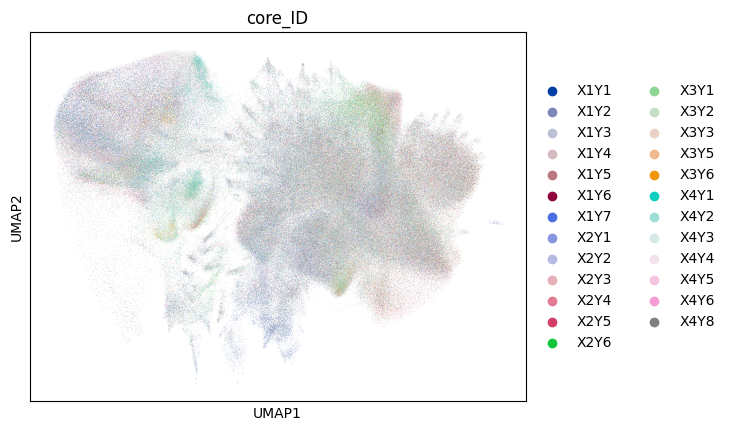

In [89]:
sc.pl.umap(
    adata_ileum,
    color=[
        "core_ID",
    ],
    wspace=0.4,
    save = '_ileum_by_core_xenium_with_metadata_res_1.png'
)

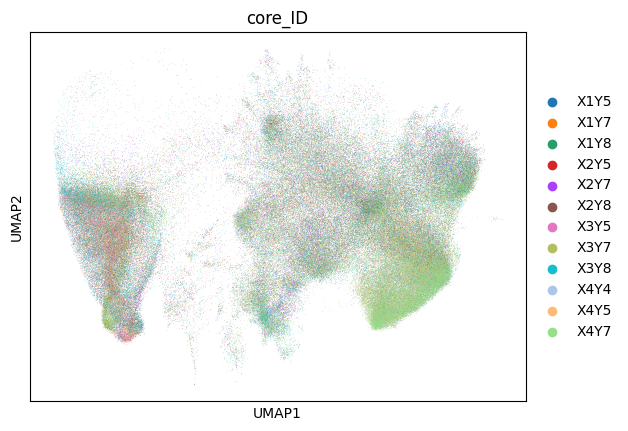

In [90]:
sc.pl.umap(
    adata_colon,
    color=[
        "core_ID",
    ],
    wspace=0.4,
    save = '_colon_by_core_xenium_with_metadata_res_1.png'
)

## Xenium QC table (for each metadata feature)

In [105]:
# Use raw counts layer if needed
if 'counts' in full_adata.layers:
    counts = full_adata.layers['counts']
else:
    counts = full_adata.X

# Calculate total transcripts and genes per cell
full_adata.obs['n_transcripts'] = counts.sum(axis=1).A1 if hasattr(counts, 'A1') else counts.sum(axis=1)
full_adata.obs['n_genes'] = (counts > 0).sum(axis=1).A1 if hasattr(counts, 'A1') else (counts > 0).sum(axis=1)

# Grouping variables
grouping_vars = ['slide_ID', 'core_ID', 'patient_ID', 'time_point', 'batch', 'year', 'tissue']

summary_stats = {}

for var in grouping_vars:
    grouped = full_adata.obs.groupby(var)
    stats = grouped.agg(
        total_cells=('n_transcripts', 'count'),
        total_transcripts=('n_transcripts', 'sum'),
        avg_transcripts_per_cell=('n_transcripts', 'mean'),
        avg_genes_per_cell=('n_genes', 'mean'),
    )
    
    df = grouped.agg(
        total_cells=('total_counts', 'count'),
        total_transcripts=('total_counts', 'sum'),
        control_probe_counts=('control_probe_counts', 'sum'),
        control_codeword_counts=('control_codeword_counts', 'sum')
    )

    df['negative_dna_pct'] = 100 * df['control_probe_counts'] / df['total_transcripts']
    df['negative_decoding_pct'] = 100 * df['control_codeword_counts'] / df['total_transcripts']
    
    summary_stats[var] = stats
    
    summary_stats[var] = summary_stats[var].join(df[['negative_dna_pct', 'negative_decoding_pct']])

/tmp/ipykernel_84262/856516033.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = full_adata.obs.groupby(var)
/tmp/ipykernel_84262/856516033.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = full_adata.obs.groupby(var)
/tmp/ipykernel_84262/856516033.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = full_adata.obs.groupby(var)
/tmp/ipykernel_84262/856516033.py:17: FutureWarning: The d

In [135]:
summary_stats['time_point'].head()

total_cells  total_transcripts  avg_transcripts_per_cell  \
time_point                                                                   
before_treatment       529906         25282688.0                 47.711647   
during_treatment       372953         30529352.0                 81.858444   

                  avg_genes_per_cell  negative_dna_pct  negative_decoding_pct  
time_point                                                                     
before_treatment           22.069233          0.045059               0.001435  
during_treatment           33.007258          0.034435               0.001745

## CODEX clustering

In [106]:
codex_channels = ['DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG',
                  'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14',
                  'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69',
                  'Podoplanin', 'PNAd']

### Before log1p transformation

In [107]:
old_adata = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata_merged_both_slides.h5ad")

# Extract only CODEX intensity data
old_X_codex = old_adata.obs[codex_channels].values

# Create new AnnData with the same obs
old_adata_codex = ad.AnnData(X=old_X_codex, obs=old_adata.obs.copy(), var=pd.DataFrame(index=codex_channels))

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [108]:
sc.pp.scale(old_adata_codex)
sc.pp.pca(old_adata_codex)
sc.pp.neighbors(old_adata_codex)
sc.tl.umap(old_adata_codex)
sc.tl.leiden(old_adata_codex, resolution=1) 

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_84262/3059502480.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(old_adata_codex, resolution=1)


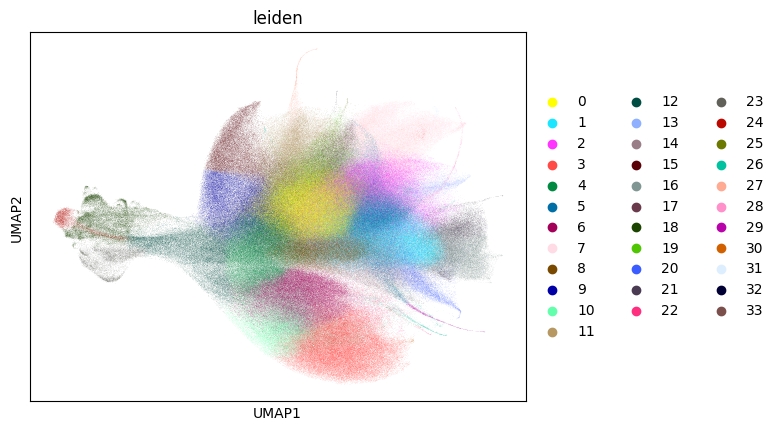

In [115]:
sc.pl.umap(old_adata_codex, color="leiden", wspace=0.4, save = '_codex_no_log1p.png')

### After log1p transformation

In [123]:
# Extract only CODEX intensity data
X_codex = full_adata.obs[codex_channels].values

# Create new AnnData with the same obs
adata_codex = ad.AnnData(X=X_codex, obs=full_adata.obs.copy(), var=pd.DataFrame(index=codex_channels))

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
sc.pp.scale(adata_codex)  
sc.pp.pca(adata_codex)
sc.pp.neighbors(adata_codex)
sc.tl.umap(adata_codex)
sc.tl.leiden(adata_codex, resolution=0.5)  

In [ ]:
sc.pl.umap(adata_codex, color="leiden", wspace=0.4, save = '_codex_log1p_res_05.png')

In [ ]:
sc.pl.umap(adata_codex, color="annotation", wspace=0.4, save = '_codex_log1p_res_05_with_xenium_annotation.png')

***maybe codex is not enough to computationnaly cluster things***

### Z-normalization -> log1p

In [141]:
raw_codex = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata_merged_both_slides.h5ad")

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
raw_codex.obs = raw_codex.obs.set_index('cell_id')

In [143]:
# Keep only the cell_ids in df
valid_cell_ids = adata_lisa_annotation.obs.index.intersection(raw_codex.obs.index)

# Subset the entire AnnData object (not just .obs!)
raw_codex = raw_codex[valid_cell_ids].copy()

In [145]:
raw_codex.obs = raw_codex.obs.join(adata_lisa_annotation.obs, how='left', rsuffix='_merged')

In [146]:
cols_to_drop = [col for col in raw_codex.obs.columns if col.endswith('_merged')]
raw_codex.obs.drop(columns=cols_to_drop, inplace=True)

In [147]:
# Optionally, reset index to get 'cell_id' back as a column
raw_codex.obs = raw_codex.obs.reset_index()

In [148]:
# Map string-based 'leiden' clusters to annotations
raw_codex.obs['annotation'] = raw_codex.obs['leiden'].map(annotation_dict)

In [149]:
# Copy var (gene metadata)
raw_codex.var = adata_lisa_annotation.var.copy()

# Copy uns (unstructured annotation, e.g., leiden, neighbors info)
raw_codex.uns = adata_lisa_annotation.uns.copy()

# Copy obsm (embeddings like PCA, UMAP, spatial)
raw_codex.obsm = adata_lisa_annotation.obsm.copy()

# Copy varm (loadings, e.g. PCs)
raw_codex.varm = adata_lisa_annotation.varm.copy()

# Copy layers (e.g. counts)
raw_codex.layers = adata_lisa_annotation.layers.copy()

# Copy obsp (neighbor graphs)
raw_codex.obsp = adata_lisa_annotation.obsp.copy()

In [153]:
cols_to_drop = ['CD163', 'CD16', 'CXCL13']
raw_codex.obs = raw_codex.obs.drop(columns=cols_to_drop)

In [154]:
output_path = "/media/Lynn/data/Integrated_data/adata_filtered_merged_both_slides_codex_raw_xenium_norm100_log_umap_leiden.h5ad"
raw_codex.write(output_path)

#### Z-norm

In [155]:
raw_adata = raw_codex.copy()
raw_adata

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 902859 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_b

In [156]:
# Store original values with new column names before normalization
print("Storing original CODEX marker values...")
for marker in codex_channels:
    raw_adata.obs[f'{marker}_original'] = raw_adata.obs[marker].copy()

print("Original CODEX marker statistics:")
print(raw_adata.obs[codex_channels].describe())

Storing original CODEX marker values...
Original CODEX marker statistics:
                DAPI          FoxP3           aSMA            CD4  \
count  902859.000000  902859.000000  902859.000000  902859.000000   
mean    11117.068236      12.254924     216.089659    2042.805793   
std      6667.206916      60.606805     545.158348    1180.083201   
min        51.980000       0.000000       0.000000       0.000000   
25%      6510.747757       1.227848       6.217782    1456.885742   
50%     10071.111111       2.413793      24.422078    1899.070707   
75%     14505.254921       4.690227     137.960655    2455.552086   
max     58802.719212    5940.655556   11491.957774   63666.030928   

                 CD8           CD31          CD11c           IFNG  \
count  902859.000000  902859.000000  902859.000000  902859.000000   
mean       19.661022     175.545010     235.539417      61.794365   
std        66.810880     205.992323     289.144241     217.898491   
min         0.000000       0

In [157]:
# Standard Z-score normalization 
print("\nApplying Z-score normalization...")
for marker in codex_channels:
    marker_values = raw_adata.obs[marker]
    
    # Calculate mean and standard deviation
    mean_val = marker_values.mean()
    std_val = marker_values.std()
    
    # Apply z-score normalization (overwrite original columns)
    raw_adata.obs[marker] = (marker_values - mean_val) / std_val
    
    print(f"{marker}: mean={mean_val:.3f}, std={std_val:.3f}")

# Verify normalization worked
print("\nNormalized CODEX marker statistics:")
print(raw_adata.obs[codex_channels].describe())

# Check for any NaN values after normalization
nan_counts = raw_adata.obs[codex_channels].isnull().sum()
if nan_counts.sum() > 0:
    print("\nWarning: NaN values found after normalization:")
    print(nan_counts[nan_counts > 0])


Applying Z-score normalization...
DAPI: mean=11117.068, std=6667.207
FoxP3: mean=12.255, std=60.607
aSMA: mean=216.090, std=545.158
CD4: mean=2042.806, std=1180.083
CD8: mean=19.661, std=66.811
CD31: mean=175.545, std=205.992
CD11c: mean=235.539, std=289.144
IFNG: mean=61.794, std=217.898
Pan-Cytokeratin: mean=233.489, std=521.044
CD68: mean=709.291, std=780.413
CD20: mean=156.102, std=501.270
CD66b: mean=73.237, std=143.118
TNFa: mean=2230.934, std=1968.817
CD45RO: mean=163.336, std=243.745
CD14: mean=222.766, std=129.011
CD11b: mean=1213.147, std=1289.168
Vimentin: mean=163.668, std=241.725
IL10: mean=164.279, std=113.628
CD45: mean=533.091, std=475.866
CCR7: mean=15.023, std=35.938
CD38: mean=160.295, std=169.820
CD69: mean=43.601, std=28.354
Podoplanin: mean=469.629, std=556.580
PNAd: mean=16.624, std=30.170

Normalized CODEX marker statistics:
               DAPI         FoxP3          aSMA           CD4           CD8  \
count  9.028590e+05  9.028590e+05  9.028590e+05  9.028590e+

In [159]:
output_path = "/media/Lynn/data/Integrated_data/adata_filtered_merged_both_slides_codex_znorm_xenium_norm100_log_umap_leiden.h5ad"
raw_adata.write(output_path)

#### log1p

In [160]:
# Apply log1p only to the CODEX channel columns
raw_adata.obs[codex_channels] = np.log1p(raw_adata.obs[codex_channels])

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [161]:
output_path = "/media/Lynn/data/Integrated_data/adata_filtered_merged_both_slides_codex_znorm_log1p_xenium_norm100_log_umap_leiden.h5ad"
raw_adata.write(output_path)

#### Cluster

In [162]:
adata_znorm_log1p = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata_filtered_merged_both_slides_codex_znorm_log1p_xenium_norm100_log_umap_leiden.h5ad")

In [163]:
# Extract only CODEX intensity data
X_codex_znorm_log1p = adata_znorm_log1p.obs[codex_channels].values

# Create new AnnData with the same obs
adata_codex_znorm_log1p = ad.AnnData(X=X_codex_znorm_log1p, obs=adata_znorm_log1p.obs.copy(), var=pd.DataFrame(index=codex_channels))

In [164]:
sc.pp.scale(adata_codex_znorm_log1p)  
sc.pp.pca(adata_codex_znorm_log1p)
sc.pp.neighbors(adata_codex_znorm_log1p)
sc.tl.umap(adata_codex_znorm_log1p)
sc.tl.leiden(adata_codex_znorm_log1p)  

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [167]:
# Check for NaN values in your normalized data
print("Checking for NaN values in CODEX channels:")
nan_summary = adata_znorm_log1p.obs[codex_channels].isnull().sum()
print(nan_summary[nan_summary > 0])

# Check for infinite values
print("\nChecking for infinite values:")
inf_summary = np.isinf(adata_znorm_log1p.obs[codex_channels]).sum()
print(inf_summary[inf_summary > 0])

Checking for NaN values in CODEX channels:
DAPI    116844
CD4      65655
TNFa     43730
CD14    130929
IL10     91202
CD45     59087
CD69     65506
dtype: int64

Checking for infinite values:
Series([], dtype: int64)


##### Log1p after Z-norm (which creates negative values) gives some NaN values -> Do clustering with Z-norm only

In [168]:
adata_znorm = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata_filtered_merged_both_slides_codex_znorm_xenium_norm100_log_umap_leiden.h5ad")

In [169]:
# Check for NaN values in your normalized data
print("Checking for NaN values in CODEX channels:")
nan_summary = adata_znorm.obs[codex_channels].isnull().sum()
print(nan_summary[nan_summary > 0])

# Check for infinite values
print("\nChecking for infinite values:")
inf_summary = np.isinf(adata_znorm.obs[codex_channels]).sum()
print(inf_summary[inf_summary > 0])

Checking for NaN values in CODEX channels:
Series([], dtype: int64)

Checking for infinite values:
Series([], dtype: int64)


In [ ]:
# Extract only CODEX intensity data
X_codex_znorm = adata_znorm.obs[codex_channels].values

# Create new AnnData with the same obs
adata_codex_znorm = ad.AnnData(X=X_codex_znorm, obs=adata_znorm.obs.copy(), var=pd.DataFrame(index=codex_channels))

In [ ]:
sc.pp.scale(adata_codex_znorm)  
sc.pp.pca(adata_codex_znorm)
sc.pp.neighbors(adata_codex_znorm)
sc.tl.umap(adata_codex_znorm)
sc.tl.leiden(adata_codex_znorm)  

In [ ]:
sc.pl.umap(adata_codex_znorm, color="leiden", wspace=0.4, save = '_codex_znorm.png')

In [ ]:
sc.pl.umap(adata_codex_znorm, color="annotation", wspace=0.4, save = '_codex_znorm_with_xenium_annotation.png')